In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
import scipy.stats
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../"))
from distance_functions import *

# On ImageNet

In [2]:
folder = "distances/train/pretrained"
stats = np.load(f"{folder}/stats.npz")
model_names = stats["model_names"]
dist_pairs_saved = stats["dist_pairs_saved"]

In [3]:
# Check that all distance pairs have been saved
for i in range(dist_pairs_saved.shape[0]):
    for j in range(i+1,dist_pairs_saved.shape[1]):
        assert(dist_pairs_saved[i,j])

In [4]:
distnames = [x[:-4] for x in os.listdir(folder) if x[-1] == 'y']
distances = {}
def symmetrize(A):
    assert(A.shape[0] == A.shape[1])
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B
for distname in distnames:
    print(distname)
    curr_dist = np.load(f"{folder}/{distname}.npy")  
    distances[distname] = symmetrize(curr_dist)
#     print(distances[distname])

lin_cka_dist
predictor_dist_1e-12
lin_cka_prime_dist
predictor_dist_1e-14
predictor_dist_1e-16
predictor_dist_1e-05
predictor_dist_1000.0
predictor_dist_0.0001
predictor_dist_1e-11
predictor_dist_0.001
predictor_dist_10.0
predictor_dist_1e-18
predictor_dist_1e-20
predictor_dist_100.0
predictor_dist_10000.0
predictor_dist_1e-13
predictor_dist_1.0
predictor_dist_1e-06
procrustes
predictor_dist_1e-07
predictor_dist_0.01
pwcca_dist_e2e
predictor_dist_1e-17
predictor_dist_0.1
predictor_dist_1e-08
mean_cca_e2e
predictor_dist_1e-15
predictor_dist_1e-09
predictor_dist_1e-19
mean_sq_cca_e2e
predictor_dist_1e-10
predictor_dist_0.0


In [5]:
pred_dists = ['predictor_dist_0.0','predictor_dist_1e-20',
 'predictor_dist_1e-19',
 'predictor_dist_1e-18',
 'predictor_dist_1e-17',
 'predictor_dist_1e-16',
 'predictor_dist_1e-15',
 'predictor_dist_1e-14',
 'predictor_dist_1e-13',
 'predictor_dist_1e-12',
 'predictor_dist_1e-11',
 'predictor_dist_1e-10',
 'predictor_dist_1e-09',
 'predictor_dist_1e-08',
 'predictor_dist_1e-07',
 'predictor_dist_1e-06',
 'predictor_dist_1e-05', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0', 'predictor_dist_100.0', 'predictor_dist_1000.0', 'predictor_dist_10000.0']

In [6]:
pred_dists = ['predictor_dist_0.0', 'predictor_dist_1e-10',
 'predictor_dist_1e-05', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1','predictor_dist_1.0','predictor_dist_10.0']

In [7]:
pred_dists

['predictor_dist_0.0',
 'predictor_dist_1e-10',
 'predictor_dist_1e-05',
 'predictor_dist_0.0001',
 'predictor_dist_0.001',
 'predictor_dist_0.01',
 'predictor_dist_0.1',
 'predictor_dist_1.0',
 'predictor_dist_10.0']

In [8]:
def vectorize_upper_triangle(A, subset_inds):
    assert(A.shape[0] == A.shape[1])
    if subset_inds is None:
        subset_inds = range(len(A.shape[0]))
    n = len(subset_inds)
    v = []
    for i in range(n):
        for j in range(i+1,n):
            c_val = A[subset_inds[i],subset_inds[j]]
            v.append(c_val)
    return np.asarray(v)

def compare_d1_to_d2s(d1, d2s, subset_inds=None, d1_name=None, d2_names=None, fsz=17, figname=None):
    d1_mat = distances[d1]
    
    
    if subset_inds is None:
        subset_inds = range(d1_mat.shape[0])
        
    d1_vec = vectorize_upper_triangle(d1_mat, subset_inds)
    
    num_d2s = len(d2s)

    if num_d2s == 9:
        sz = 4
        plt.subplots(3,3, figsize=(3 * sz, 3 * sz))
    elif num_d2s == 4:
        sz = 4
        plt.subplots(1,4, figsize=(4 * sz, 1 * sz))
    elif num_d2s == 3:
        sz = 5
        plt.subplots(1,3, figsize=(3 * sz, 1 * sz))
    elif num_d2s == 7:
        sz = 4
        plt.subplots(1,7, figsize=(7 * sz, 1 * sz))
    elif num_d2s == 5:
        sz = 4
        plt.subplots(1,7, figsize=(5 * sz, 1 * sz))
    else:
        assert(False)
            
    for i, d2 in enumerate(d2s):
        d2_mat = distances[d2]
        d2_vec = vectorize_upper_triangle(d2_mat, subset_inds)
        
        good_inds = np.asarray([i for i in range(len(d2_vec)) if d1_vec[i] > 0 and d2_vec[i] > 0])
        
        if len(good_inds) < len(d2_vec):
            print('WARNING: some distances that are < 0 were removed')
        
        d1_filtered = d1_vec[good_inds]
        d2_filtered = d2_vec[good_inds]
        
        if num_d2s == 9:
            plt.subplot(3,3, i+1)
        elif num_d2s == 4:
            plt.subplot(1,4,i+1)
        elif num_d2s == 3:
            plt.subplot(1,3,i+1)
        elif num_d2s == 7:
            plt.subplot(1,7,i+1)
        elif num_d2s == 5:
            plt.subplot(1,5,i+1)
        plt.scatter(d2_filtered, d1_filtered, marker='.', s=5)
#         plt.axis('equal')
        if d2_names is None:
            plt.xlabel(d2, fontsize=fsz)
        else:
            plt.xlabel(d2_names[i], fontsize=fsz)
        if d1_name is None:
            plt.ylabel(d1, fontsize=fsz)
        else:
            plt.ylabel(d1_name, fontsize=fsz)
            
        plt.yticks(fontsize=fsz-2)
        plt.xticks(fontsize=fsz-2)
        
        pearsonr = scipy.stats.pearsonr(d2_filtered, d1_filtered)
        plt.title(f"Correlation: {pearsonr[0]:.3f}", fontsize=fsz-2)

    plt.tight_layout(pad=3.0)
    if figname:
        plt.savefig('../paper_figures/' + figname)
    plt.show()
        

In [9]:
# Figures for the main text
pred_dists = ['predictor_dist_0.0',
 'predictor_dist_0.01',
 'predictor_dist_1.0']

subset_inds = range(len(model_names))

d2_names = ['GULP, $\lambda = 0$', 'GULP, $\lambda = 10^{-2}$', 'GULP, $\lambda = 1$']

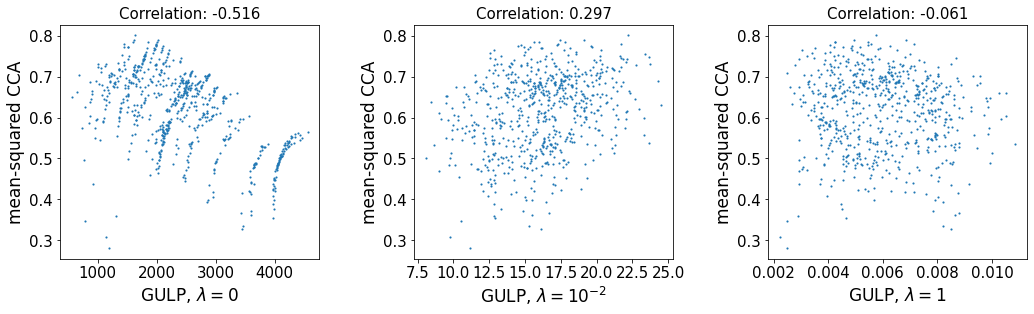

In [10]:
d1_name = 'mean-squared CCA'
compare_d1_to_d2s('mean_sq_cca_e2e', pred_dists, d1_name=d1_name, d2_names=d2_names, subset_inds=subset_inds, figname='cca_vs_gulp_imagenet.pdf')

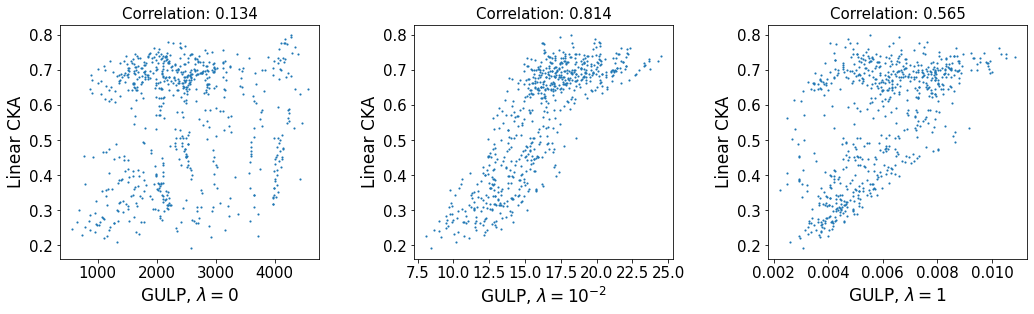

In [11]:
d1_name = 'CKA'
compare_d1_to_d2s('lin_cka_dist', pred_dists, d1_name='Linear CKA', d2_names=d2_names, subset_inds=subset_inds, figname='cka_vs_gulp_imagenet.pdf')

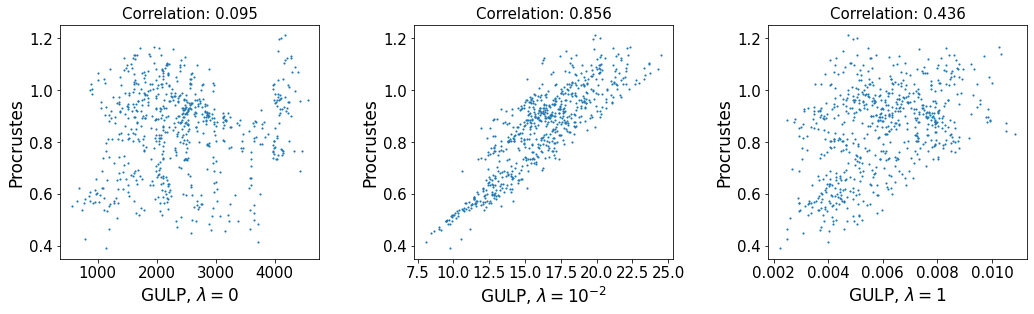

In [12]:
compare_d1_to_d2s('procrustes', pred_dists, subset_inds=subset_inds, d1_name='Procrustes', d2_names=d2_names)

## Extended figures

In [13]:
pred_dists = ['predictor_dist_0.0',
#  'predictor_dist_0.0001',
 'predictor_dist_0.001',
 'predictor_dist_0.01',
  'predictor_dist_0.1',
 'predictor_dist_1.0'
             ]

d2_names = ['GULP, $\lambda = 0$',
#             'GULP, $\lambda = 10^{-4}$',
            'GULP, $\lambda = 10^{-3}$',
            'GULP, $\lambda = 10^{-2}$',
            'GULP, $\lambda = 10^{-1}$',
            'GULP, $\lambda = 1$',
           ]

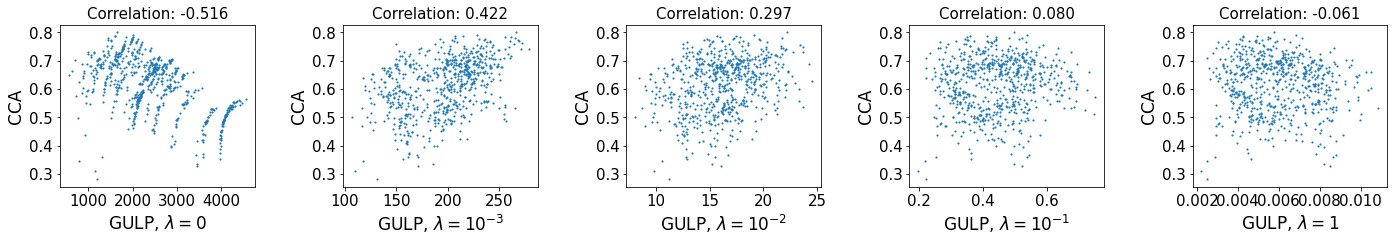

In [14]:
d1_name = 'CCA'
compare_d1_to_d2s('mean_sq_cca_e2e', pred_dists, d1_name=d1_name, d2_names=d2_names, subset_inds=subset_inds, figname='cca_vs_gulp_extended_imagenet.pdf')

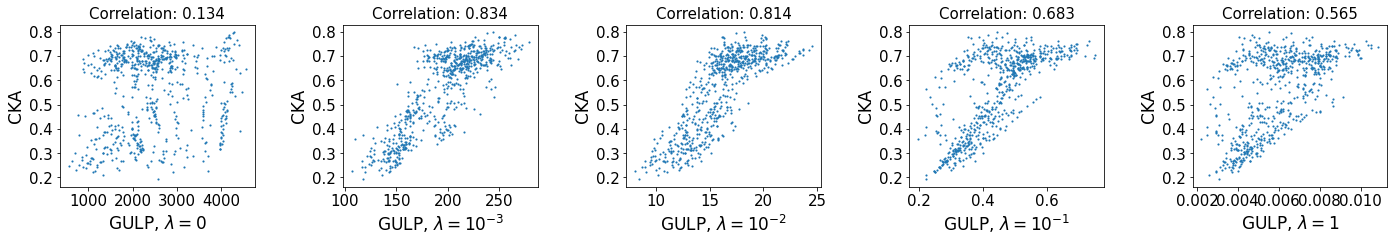

In [15]:
d1_name = 'CKA'
compare_d1_to_d2s('lin_cka_dist', pred_dists, d1_name=d1_name, d2_names=d2_names, subset_inds=subset_inds, figname='cka_vs_gulp_extended_imagenet.pdf')

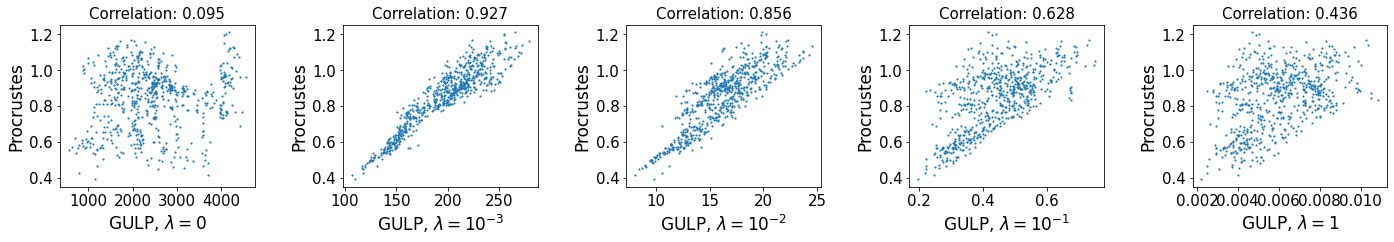

In [16]:
d1_name = 'Procrustes'
compare_d1_to_d2s('procrustes', pred_dists, d1_name=d1_name, d2_names=d2_names, subset_inds=subset_inds, figname='procrustes_vs_gulp_extended_imagenet.pdf')

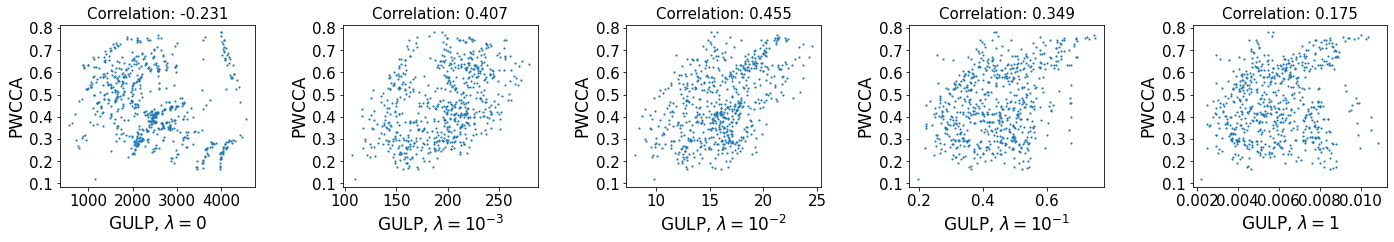

In [17]:
d1_name = 'PWCCA'
compare_d1_to_d2s('pwcca_dist_e2e', pred_dists, d1_name=d1_name, d2_names=d2_names, subset_inds=subset_inds, figname='pwcca_vs_gulp_extended_imagenet.pdf')